# Evaluating ENSO Predictability Using CESM2-SMYLE

**ATMS 523 – Module 8: Student Choice Project**  
Author: *Yudi Mao*  

---
### 1. Motivation

ENSO (El Niño–Southern Oscillation) is the dominant mode of interannual climate variability, and predicting its evolution months in advance is important for impacts on agriculture, hydrology, and weather extremes.

In this project, I build an **end-to-end, reproducible workflow** to evaluate short-lead ENSO prediction skill using the CESM2-SMYLE decadal prediction system. The analysis demonstrates techniques from ATMS 523, including:

- accessing and working with gridded climate data in Python using `xarray`
- computing a regional ENSO index (Niño-3.4) and anomalies
- applying time-series based skill metrics (ACC and RMSE)
- visualizing results with `matplotlib`
- tracking the workflow with Git and GitHub.


---
### 2. Data & References

**Primary dataset**  
- CESM2-SMYLE decadal prediction system  
- Yeager, S. G., et al. (2022): *An Initialized Decadal Prediction Large Ensemble with the CESM2.* Journal of Advances in Modeling Earth Systems.  
- DOI: **10.1029/2021MS002529**

**Variable**  
- Near-surface ocean temperature (SST; e.g., variable name `tos`)

**Spatial focus**  
- Niño-3.4 region: **5°S–5°N, 170°W–120°W**

**Forecast configuration (in this notebook)**  
- Initialization years and leads follow the CESM2-SMYLE configuration used in this analysis.

Observational reference datasets for validation include:  
- HadISST — Rayner et al. (2003), DOI: 10.1029/2002JD002670


---
### 3. Workflow Overview

This notebook implements the following steps:

1. Load CESM2-SMYLE SST hindcast data.
2. Compute a Niño-3.4 SST index from the model fields.
3. Compute anomalies relative to a climatology.
4. Evaluate ENSO prediction skill using:
   - Anomaly Correlation Coefficient (**ACC**)
   - Root-Mean-Square Error (**RMSE**)
5. Visualize the skill as a function of forecast lead time.


---
### 4. Analysis Code

The following cells contain the Python analysis used to compute the Niño-3.4 index, anomalies, and
skill metrics (ACC and RMSE), and to generate the figures used in the project.


In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal
from scipy.signal import detrend
import scipy
import xesmf as xe
import xskillscore as xs
from esp_lab import data_access, stats as esp_stats
from matplotlib.ticker import FormatStrFormatter
import calendar

In [2]:
# Load SMYLE dataset
ds_SMYLE = xr.open_dataset('/glade/work/yudim/data_SST_SMYLE_197002_201911_all_ens_new.nc')
da_SMYLE = ds_SMYLE.rename({'__xarray_dataarray_variable__': 'T'})['T']

# Load HadISST dataset
ds_HadISST = xr.open_dataset('/glade/u/home/yudim/research/HadISST_sst.nc')
ds_HadISST['sst'] = xr.where(ds_HadISST['sst'] < -2, -1.8, ds_HadISST['sst'])
ds_HadISST = ds_HadISST.reindex(latitude=ds_HadISST.latitude[::-1])

# Calculate Nino 3.4 index from HadISST
nino34_HadISST = ds_HadISST.sel(latitude=slice(-5, 5), longitude=slice(-170, -120)).mean(("longitude", "latitude"))['sst']

# Process SMYLE data and apply detrending
for monmon in [2, 8]:
    for ens in [1, 5, 10, 20]:
        # Define initialization time range based on month
        if monmon == 2:
            init_time_range = pd.date_range(start=f'1982-{monmon:02d}-01', end=f'2016-{monmon:02d}-01', freq='YS-FEB')
        elif monmon == 8:
            init_time_range = pd.date_range(start=f'1982-{monmon:02d}-01', end=f'2016-{monmon:02d}-01', freq='YS-AUG')

        # Select the specified ensemble size and average
        if ens == 1:
            nino34_mean = da_SMYLE.sel(init_time=init_time_range).isel(ens=[0]).mean(dim='ens').squeeze()
        elif ens == 5:
            nino34_mean = da_SMYLE.sel(init_time=init_time_range).isel(ens=[0, 1, 2, 3, 4]).mean(dim='ens').squeeze()
        elif ens == 10:
            nino34_mean = da_SMYLE.sel(init_time=init_time_range).isel(ens=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).mean(dim='ens').squeeze()
        elif ens == 20:
            nino34_mean = da_SMYLE.sel(init_time=init_time_range).mean(dim='ens').squeeze()

        # Create a copy to store detrended data
        nino34_detrend = nino34_mean.copy()

        # Detrend each time series along the lead time dimension
        for i in range(nino34_mean.shape[0]):
            nino34_detrend[i, :] = scipy.signal.detrend(nino34_mean[i, :].values.squeeze(), axis=-1, type='linear', bp=0, overwrite_data=False)

        # Save the mean detrended Nino 3.4 series using dynamic variable names
        globals()[f'nino34_mean_1982_2016_SMYLE_{ens}_{monmon}'] = nino34_detrend.mean(dim='init_time').values

# Convert HadISST time to the first day of each month for alignment
time_HadISST = pd.to_datetime(nino34_HadISST.time).floor('D') + pd.offsets.MonthBegin(-1)

# Initialize the array to store HadISST results
nino34_mean_1982_2016_HadISST_array = np.empty((24, 4))

# Process HadISST for each initialization month
for monmon in [2, 5, 8, 11]:
    # Define initialization time range based on month
    if monmon == 2:
        init_time_range = pd.date_range(start=f'1982-{monmon:02d}-01', end=f'2016-{monmon:02d}-01', freq='YS-FEB')
    elif monmon == 8:
        init_time_range = pd.date_range(start=f'1982-{monmon:02d}-01', end=f'2016-{monmon:02d}-01', freq='YS-AUG')
        
    nino34_mean_SMYLE = da_SMYLE.sel(init_time=init_time_range)

    # Loop over lead times
    for lead_ind_ref in range(1, 25):
        validation_date_ref = pd.to_datetime(nino34_mean_SMYLE.init_time) + pd.offsets.MonthBegin(lead_ind_ref - 1)
        nino34_HadISST_sel = nino34_HadISST.sel(time=time_HadISST.isin(validation_date_ref)).values
        nino34_HadISST_detrend = detrend(nino34_HadISST_sel)
        nino34_series_mean = pd.Series(nino34_HadISST_detrend).mean()
        nino34_mean_1982_2016_HadISST_array[lead_ind_ref - 1, (monmon + 1) // 3 - 1] = nino34_series_mean
        
# Calculate the final overall mean
nino34_mean_1982_2016_HadISST = np.mean(nino34_mean_1982_2016_HadISST_array)


In [3]:
def calculate_and_plot_metrics_dual(da_SMYLE, ds_SMYLE, nino34_HadISST, time_HadISST,
                                    nino34_mean_dict, nino34_mean_1982_2016_HadISST):
    fig, axs = plt.subplots(2, 2, figsize=(14, 7.5)) 
    ensemble_sizes = [1, 5, 10, 20]  # Ensemble sizes to compare
    init_months = [2, 8] 
    metrics = ['corr', 'rmse']

    colors = {20: 'k', 10: 'r', 5: 'g', 1: 'b'} 
    subplot_labels = ['(a)', '(b)', '(c)', '(d)'] 
    
    all_results = {mon: {metric: {} for metric in metrics} for mon in init_months}


    for i, metric in enumerate(metrics):
        for j, mon in enumerate(init_months):
            # Initialize result storage
            results = {ens: np.empty((24,)) for ens in ensemble_sizes}  

            # Loop over lead months
            for lead_ind in range(1, 25):  
                selected_mon_data = {}
                for ens in ensemble_sizes:
                    # Select ensemble members
                    ens_indices = slice(0, ens) if ens != 20 else slice(None) 
                    selected_mon_data[ens] = da_SMYLE.sel(init_time=ds_SMYLE['init_time'].dt.month == mon,
                                                          time=ds_SMYLE['time'] == lead_ind).isel(ens=ens_indices).mean(dim='ens').squeeze()

                for ens in ensemble_sizes:
                    anomaly = selected_mon_data[ens] - nino34_mean_dict[(ens, mon)][lead_ind - 1]
                    validation_date = pd.to_datetime(selected_mon_data[ens].init_time) + pd.offsets.MonthBegin(lead_ind - 1)
                    obs = nino34_HadISST.sel(time=time_HadISST.isin(validation_date)) - nino34_mean_1982_2016_HadISST

                    # Remove linear trend from observations
                    obs_detrended = detrend(obs.values)  
                    model_detrended = detrend(anomaly.values.squeeze()) 

                    if metric == 'rmse':
                        mse = ((model_detrended - obs_detrended) ** 2).mean()
                        sigobs = obs.std('time')
                        # Normalized RMSE
                        result = np.sqrt(mse) / sigobs 
                    elif metric == 'corr':
                        corr_matrix = np.corrcoef(model_detrended, obs_detrended)
                        result = corr_matrix[0, 1] 

                    results[ens][lead_ind - 1] = result

            all_results[mon][metric] = results

            xlabel = np.arange(1, 25)
            ax = axs[i, j]
            
            for ens in ensemble_sizes:
                ax.plot(xlabel, results[ens], linewidth=4, linestyle='-', color=colors[ens], label=f'ens = {ens}')

            # Only show legend for the first subplot
            if i == 0 and j == 0:
                ax.legend(fontsize=15, loc='upper right')

            ax.set_xlabel('Lead Time', fontsize=15, fontweight='bold')
            ylabel = 'RMSE' if metric == 'rmse' else 'Correlation Coefficient'
            ax.set_ylabel(ylabel, fontsize=15, fontweight='bold')

            title_prefix = 'SSTA RMSE' if metric == 'rmse' else 'SSTA Correlation Coefficient'
            subplot_index = i * 2 + j
            ax.set_title(f'{subplot_labels[subplot_index]} {title_prefix}',
                         fontsize=15, fontweight='bold', loc='left')

            ax.set_title(f'Initialized in {calendar.month_abbr[mon]}',
             fontsize=15, fontweight='bold', loc='right')


            ax.set_xticks(np.concatenate((np.arange(1, 28, 4), [24])))
            ax.set_xticklabels(np.concatenate((np.arange(1, 28, 4), [24])), fontsize=15)

            if metric == 'rmse':
                ax.set_yticks(np.arange(0.2, 2.4, 0.4))
                ax.set_ylim(0.2, 2)
            else:
                ax.set_yticks(np.arange(0, 1.2, 0.2))
                ax.set_ylim(0, 1)

            ax.set_yticklabels(ax.get_yticks(), fontsize=15)
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            ax.set_xlim(xlabel[0], xlabel[-1])

            for spine in ax.spines.values():
                spine.set_linewidth(2)

            ax.grid(True, linewidth=2, color='gray', linestyle='--')

            ax.tick_params(axis='both', which='major', labelsize=15)

    plt.tight_layout()
    plt.savefig("fig1_RMSE_corr_time_series_SMYLE_HadISST.png", bbox_inches='tight')
    plt.show()
    
    print("\n=== ACC Improvement (ens=20 vs ens=1) ===")
    # Feb 初始化：Lead 3-5 (Apr-Jun)
    feb_acc_ens1 = all_results[2]['corr'][1][2:5].mean()   # ens=1, lead=3-5
    feb_acc_ens20 = all_results[2]['corr'][20][2:5].mean()
    print(f"Feb init (Apr-Jun, lead 3-5): ens=1 = {feb_acc_ens1:.2f}, ens=20 = {feb_acc_ens20:.2f}, ΔACC = {feb_acc_ens20 - feb_acc_ens1:.2f}")

    # Aug 初始化：Lead 9-11 (Apr-Jun of next year, roughly Month ≥9)
    aug_acc_ens1 = all_results[8]['corr'][1][8:11].mean()
    aug_acc_ens20 = all_results[8]['corr'][20][8:11].mean()
    print(f"Aug init (2nd Apr-Jun lead 9-11): ens=1 = {aug_acc_ens1:.2f}, ens=20 = {aug_acc_ens20:.2f}, ΔACC = {aug_acc_ens20 - aug_acc_ens1:.2f}")


In [4]:
nino34_mean_1982_2016_SMYLE_dict = {}
for ens in [1, 5, 10, 20]:
    for mon in [2, 8]:
        nino34_mean_1982_2016_SMYLE_dict[(ens, mon)] = globals()[f'nino34_mean_1982_2016_SMYLE_{ens}_{mon}']



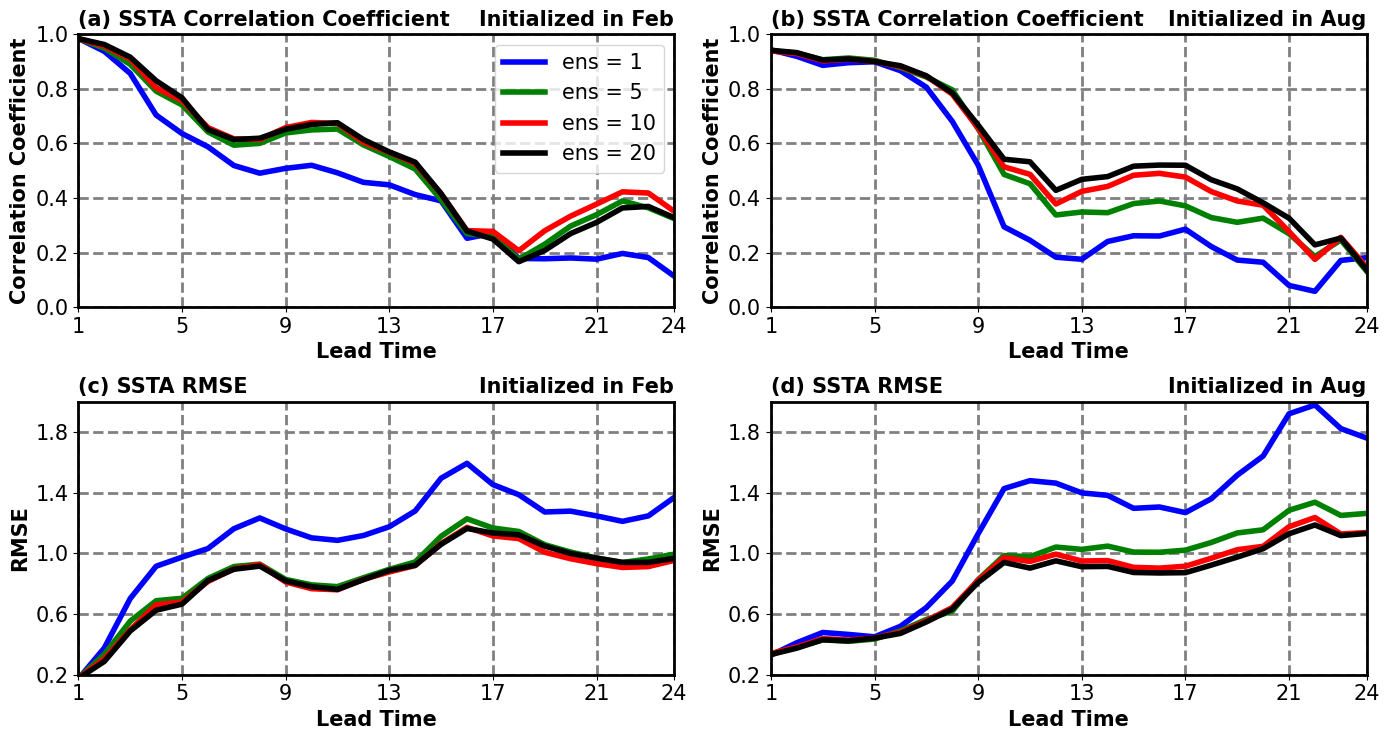


=== ACC Improvement (ens=20 vs ens=1) ===
Feb init (Apr-Jun, lead 3-5): ens=1 = 0.73, ens=20 = 0.84, ΔACC = 0.11
Aug init (2nd Apr-Jun lead 9-11): ens=1 = 0.35, ens=20 = 0.58, ΔACC = 0.23


In [5]:
calculate_and_plot_metrics_dual(da_SMYLE, ds_SMYLE, nino34_HadISST, time_HadISST,
                                nino34_mean_dict=nino34_mean_1982_2016_SMYLE_dict,
                                nino34_mean_1982_2016_HadISST=nino34_mean_1982_2016_HadISST)


---
### 5. Results Summary

Based on the CESM2-SMYLE hindcasts analyzed in this notebook, the ENSO (Niño-3.4) prediction skill
shows the following general behavior:

- **ACC** is highest at short lead times and decreases as lead increases, consistent with a loss of
  predictive information as the forecast evolves away from the initial conditions.
- **RMSE** tends to increase with lead time, reflecting growing forecast error.
- Larger ensemble sizes, stronger prediction skills.
- The overall pattern is qualitatively consistent with well-known ENSO predictability characteristics
  found in previous studies.

